In [1]:

#######################################################################
#                                                                     #
#  Copyright 2016 Theodore D Drivas                                   #
#                                                                     #
#  This file is part of pyTurbTraj.                                   #
#                                                                     #
#  pyTurbTraj is free software: you can redistribute it and/or modify #
#  it under the terms of the GNU General Public License as published  #
#  by the Free Software Foundation, either version 3 of the License,  #
#  or (at your option) any later version.                             #
#                                                                     #
#  pyTurbTraj is distributed in the hope that it will be useful,      #
#  but WITHOUT ANY WARRANTY; without even the implied warranty of     #
#  MERCHANTABILITY or FITNESS FOR A PARTICULAR PURPOSE.  See the      #
#  GNU General Public License for more details.                       #
#                                                                     #
#  You should have received a copy of the GNU General Public License  #
#  along with pyTurbTraj.  If not, see <http://www.gnu.org/licenses/> #
#                                                                     #
#######################################################################

import numpy as np

%matplotlib nbagg
import matplotlib.pyplot as plt

from tools import *

In [32]:
databases      = np.array(['channel', 'isotropic'])  
which_database = databases[1]
    
if which_database == 'channel':
    nu    = 5e-5  
    DB = info
    file_title = '_Channel'
    folder = 'data_channel/'
elif which_database == 'isotropic':
    DB = info_iso
    nu    = DB['nu'] 
    file_title = '_Isotropic'
    folder = 'data_isotropic/'
    
Lx = DB['lx']
Ly = DB['ly']
Lz = DB['lz']

Top    =  Ly/2
Bottom = -Ly/2

t   = get_timeline(which_database, subdiv = 2) #make sure subdiv is same here as in data
tau = t[0] - t

PrandtlNumbers = np.array([1e1, 1e-0, 1e-1])   

npoints    = 1
nparticles = 1000

In [ ]:
suffix = file_title + '_data_points_{0}_particles_{1}.p'.format(npoints, nparticles)
if which_database == 'channel':
    x       = pickle.load( open( folder + "x"     + suffix, "rb" ) )
    LT      = pickle.load( open( folder + "LT"    + suffix, "rb" ) )
    LB      = pickle.load( open( folder + "LB"    + suffix, "rb" ) )
    HT      = pickle.load( open( folder + "HT"    + suffix, "rb" ) )
    disp    = pickle.load( open( folder + "disp"  + suffix, "rb" ) )
elif which_database == 'isotropic':
    x       = pickle.load( open( folder + "x"     + suffix, "rb" ) )
    disp    = pickle.load( open( folder + "disp"  + suffix, "rb" ) )

<IPython.core.display.Javascript object>


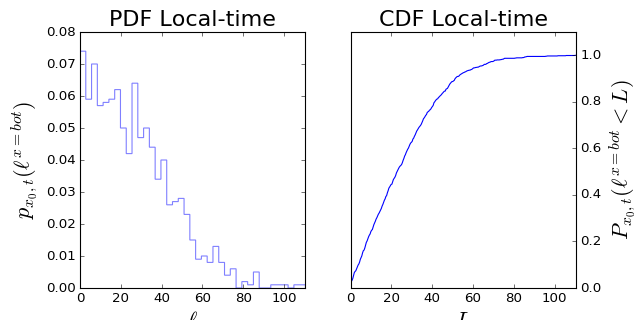

<IPython.core.display.Javascript object>


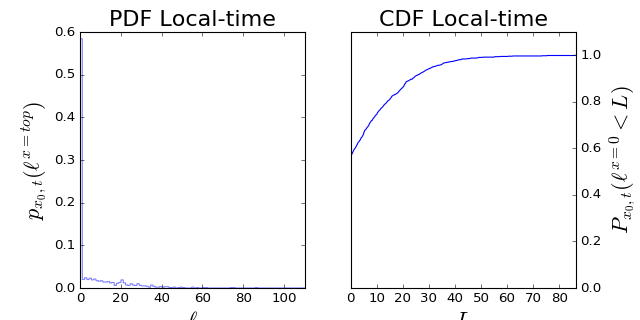

In [139]:
space_index   = 0
Pr_ind        = 1
dataB         = LB[Pr_ind,space_index,:,1]
dataT         = LT[Pr_ind,space_index,:,1]
MB            = np.max(dataB)
MT            = np.max(dataT)

fig = plt.figure(figsize=(8,4))

ax1 = fig.add_subplot(121)
ax2 = fig.add_subplot(122)
fig.subplots_adjust(hspace=.5)

####################################
######## BOTTOM LOCAL TIME #########
####################################

bins = np.linspace(0, MB, 40)
N = nparticles
weights = np.ones_like(dataB[:])/N
ax1.hist(dataB, weights = weights, bins = bins, alpha=0.5, histtype = 'step')
#ax1.hist(dataB, normed = 1, bins = bins, alpha=0.5, histtype = 'step')

ax1.set_title('PDF Local-time', fontsize=20)
ax1.set_xlim([0,MB])
ax1.set_xlabel('$\ell$', fontsize=20)
ax1.set_ylabel('$p_{x_0,t}(\\ell^{x=bot})$', fontsize=20)

values, base = np.histogram(dataB, bins = 300, normed = 0)
cumulative   = np.cumsum(values)/float(dataB.shape[0])
ax2.plot(base[:-1], cumulative, c='blue')

ax2.set_xlim([0,MB])
ax2.set_ylim([0,1.1])
ax2.set_title('CDF Local-time', fontsize=20)
ax2.set_xlabel('$L$', fontsize=20)
ax2.yaxis.tick_right()
ax2.yaxis.set_label_position("right")
ax2.set_ylabel('$P_{x_0,t}(\\ell^{x=bot}<L)$', fontsize=20)


fig = plt.figure(figsize=(8,4))

ax1 = fig.add_subplot(121)
ax2 = fig.add_subplot(122)
fig.subplots_adjust(hspace=.5)

####################################
########## TOP LOCAL TIME ##########
####################################

bins = np.linspace(0, MB, 100)
N = nparticles
weights = np.ones_like(dataT[:])/N
ax1.hist(dataT, weights = weights, bins = bins, alpha=0.5, histtype = 'step')

ax1.set_title('PDF Local-time', fontsize=20)
ax1.set_xlim([0,MB])
ax1.set_xlabel('$\ell$', fontsize=20)
ax1.set_ylabel('$p_{x_0,t}(\\ell^{x=top})$', fontsize=20)

values, base = np.histogram(dataT, bins = 300, normed = 0)
cumulative   = np.cumsum(values)/float(dataT.shape[0])
ax2.plot(base[:-1], cumulative, c='blue')

ax2.set_xlim([0,MT])
ax2.set_ylim([0,1.1])
ax2.set_title('CDF Local-time', fontsize=20)
ax2.set_xlabel('$L$', fontsize=20)
ax2.yaxis.tick_right()
ax2.yaxis.set_label_position("right")
ax2.set_ylabel('$P_{x_0,t}(\\ell^{x=0}<L)$', fontsize=20)

<IPython.core.display.Javascript object>


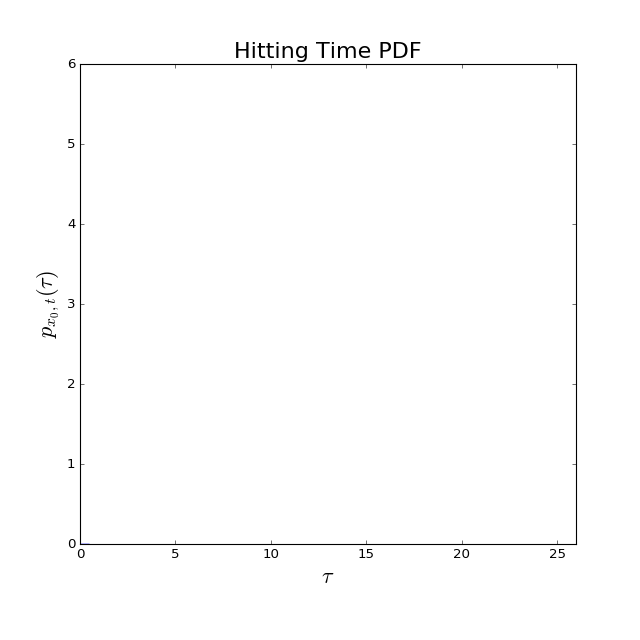

In [114]:
space_index = 1
Pr_ind      = 0

data = HT[Pr_ind, space_index, :, np.newaxis]
data = data[data < 2*T]
MD = np.max(data)

fig = plt.figure(figsize=(8,8))
ax1 = fig.add_subplot(111)
fig.subplots_adjust(hspace=.5)

plt.gcf().subplots_adjust(bottom=0.15)

N = nparticles/5.
weights1 = np.ones_like(data[:])/N

ax1.hist(data, weights = weights1, bins = 60, alpha=0.5,  histtype = 'step')
taus = np.linspace(0.001, T, 350)
ax1.set_title('Hitting Time PDF', fontsize=20)
ax1.set_xlim([0,T])
ax1.set_xlabel('$\\tau$', fontsize=20)
ax1.set_ylabel('$p_{x_0,t}(\\tau)$', fontsize=20)

In [30]:
space_point_index = 1
kolmogorov_time = 1

half_Channel_Width = (1/2)*(Top-Bottom)

kappa1 = nu/PrandtlNumbers[0]
kappa2 = nu/PrandtlNumbers[1]
#kappa3 = nu/PrandtlNumbers[2]

Tau = tau/float(kolmogorov_time)
diffusion_dispersion1 = 12*kappa1*Tau
diffusion_dispersion2 = 12*kappa2*Tau
#diffusion_dispersion3 = 12*kappa3*Tau
Richardson_dispersion = 1e-3*Tau**3

disper1 = disp[0,:, space_point_index]/float(half_Channel_Width**2)
disper2 = disp[1,:, space_point_index]/float(half_Channel_Width**2)
#disper3 = disp[2,:, space_point_index]/float(half_Channel_Width**2)

fig = plt.figure(figsize=(8,8))
ax = fig.add_subplot(111)
ax.plot(Tau, disper1, color = 'Indianred', label = '$Pr = {0}$'.format(PrandtlNumbers[0]))
ax.plot(Tau, disper2, color = 'Steelblue', label = '$Pr = {0}$'.format(PrandtlNumbers[1]))
#ax.plot(Tau, disper3, color = 'green', label = '$Pr = {0}$'.format(PrandtlNumbers[2]))
ax.plot(Tau, diffusion_dispersion1,   color = 'black', linestyle = 'dashed',  label = '$1.2\ \\nu\\tau$')
ax.plot(Tau, diffusion_dispersion2,   color = 'black', linestyle = 'dashdot', label = '$12\  \\nu \\tau$')
#ax.plot(Tau, diffusion_dispersion3,   color = 'black', linestyle = 'dotted',  label = '$120\  \\nu \\tau$')
ax.plot(Tau, Richardson_dispersion,   color = 'black', linestyle = 'solid',   label = '$10^{-4} \\tau^3$')
ax.set_xlim([10**(-3),10**(1.4)])
ax.set_ylim([10**(-4.5),10**(5)])
ax.set_title('$\\rm Mean-Squared\ Dispersion\ of\ Particles\ Ending\ at\ \\mathbf{x}$', fontsize=20)
ax.set_xlabel('$\\tau $', fontsize=20)
ax.set_ylabel('$\mathbb{E}^{1,2} |{\\xi}^{(1)}_{t,\\tau}(\\mathbf{x})-{\\xi}^{(2)}_{t,\\tau}(\\mathbf{x})|^2 /(L_y/2)^2$', fontsize=20)
ax.set_yscale('log')
ax.set_xscale('log')
ax.legend(loc ="best")

NameError: name 'nu' is not defined

In [36]:
####### Load Data #######
t   = get_timeline('channel', subdiv = 3) #make sure subdiv is same here as in data
tau = t[0] - t
PrandtlNumbers = np.array([1e0, 1e-1, 1e-2, 1e-3])   

npoints    = 1
nparticles = 2000
suffix1 = '_Points_{0}_Traj_{1}_Pr_{2}.p'.format(npoints, nparticles, PrandtlNumbers[0])
suffix2 = '_Points_{0}_Traj_{1}_Pr_{2}.p'.format(npoints, nparticles, PrandtlNumbers[1])
LT1      = pickle.load( open( "data_channel/LT"    + suffix1, "rb" ) )
LB1      = pickle.load( open( "data_channel/LB"    + suffix1, "rb" ) )
HT1      = pickle.load( open( "data_channel/HT"    + suffix1, "rb" ) )
disp1    = pickle.load( open( "data_channel/disp"  + suffix1, "rb" ) )
LT2      = pickle.load( open( "data_channel/LT"    + suffix2, "rb" ) )
LB2      = pickle.load( open( "data_channel/LB"    + suffix2, "rb" ) )
HT2      = pickle.load( open( "data_channel/HT"    + suffix2, "rb" ) )
disp2    = pickle.load( open( "data_channel/disp"  + suffix2, "rb" ) )

<IPython.core.display.Javascript object>


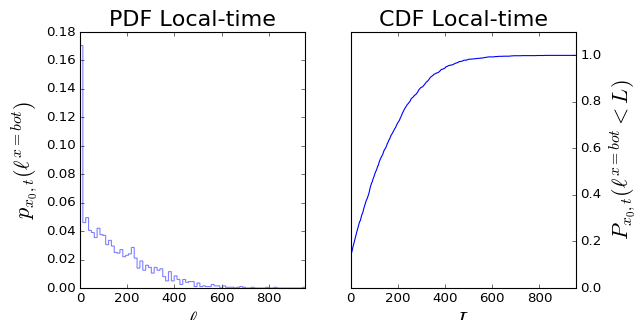

<IPython.core.display.Javascript object>


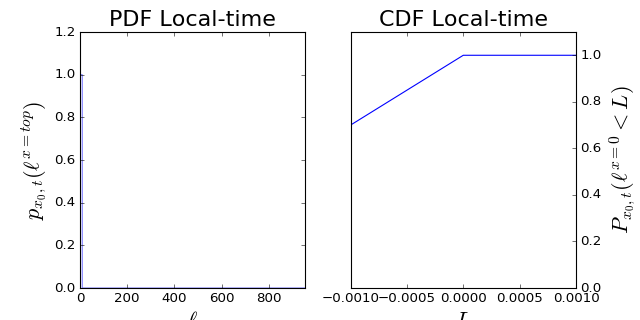

In [37]:
space_index   = 0
dataB         = LB2[space_index,:,1]
dataT         = LT2[space_index,:,1]
MB            = np.max(dataB)
MT            = np.max(dataT)

fig = plt.figure(figsize=(8,4))

ax1 = fig.add_subplot(121)
ax2 = fig.add_subplot(122)
fig.subplots_adjust(hspace=.5)

####################################
######## BOTTOM LOCAL TIME #########
####################################

bins = np.linspace(0, MB, 80)
N = nparticles
weights = np.ones_like(dataB[:])/N
ax1.hist(dataB, weights = weights, bins = bins, alpha=0.5, histtype = 'step')

ax1.set_title('PDF Local-time', fontsize=20)
ax1.set_xlim([0,MB])
ax1.set_xlabel('$\ell$', fontsize=20)
ax1.set_ylabel('$p_{x_0,t}(\\ell^{x=bot})$', fontsize=20)

values, base = np.histogram(dataB, bins = 300, normed = 0)
cumulative   = np.cumsum(values)/float(dataB.shape[0])
ax2.plot(base[:-1], cumulative, c='blue')

ax2.set_xlim([0,MB])
ax2.set_ylim([0,1.1])
ax2.set_title('CDF Local-time', fontsize=20)
ax2.set_xlabel('$L$', fontsize=20)
ax2.yaxis.tick_right()
ax2.yaxis.set_label_position("right")
ax2.set_ylabel('$P_{x_0,t}(\\ell^{x=bot}<L)$', fontsize=20)


fig = plt.figure(figsize=(8,4))

ax1 = fig.add_subplot(121)
ax2 = fig.add_subplot(122)
fig.subplots_adjust(hspace=.5)

####################################
########## TOP LOCAL TIME ##########
####################################

bins = np.linspace(0, MB, 100)
N = nparticles
weights = np.ones_like(dataT[:])/N
ax1.hist(dataT, weights = weights, bins = bins, alpha=0.5, histtype = 'step')

ax1.set_title('PDF Local-time', fontsize=20)
ax1.set_xlim([0,MB])
ax1.set_xlabel('$\ell$', fontsize=20)
ax1.set_ylabel('$p_{x_0,t}(\\ell^{x=top})$', fontsize=20)

values, base = np.histogram(dataT, bins = 300, normed = 0)
cumulative   = np.cumsum(values)/float(dataT.shape[0])
ax2.plot(base[:-1], cumulative, c='blue')

ax2.set_xlim([0,MT])
ax2.set_ylim([0,1.1])
ax2.set_title('CDF Local-time', fontsize=20)
ax2.set_xlabel('$L$', fontsize=20)
ax2.yaxis.tick_right()
ax2.yaxis.set_label_position("right")
ax2.set_ylabel('$P_{x_0,t}(\\ell^{x=0}<L)$', fontsize=20)

<IPython.core.display.Javascript object>


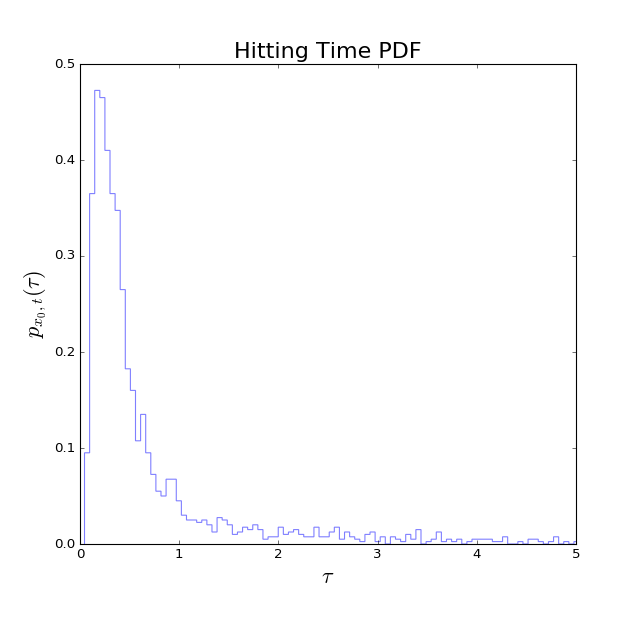

In [29]:
space_index = 0
T = t[0]
data = HT2[space_index, :, np.newaxis]
data = data[data < 2*T]
MD = np.max(data)

fig = plt.figure(figsize=(8,8))
ax1 = fig.add_subplot(111)
fig.subplots_adjust(hspace=.5)

plt.gcf().subplots_adjust(bottom=0.15)

N = nparticles/5.
weights1 = np.ones_like(data[:])/N

ax1.hist(data, weights = weights1, bins = 500, alpha=0.5,  histtype = 'step')
taus = np.linspace(0.001, T, 350)
ax1.set_title('Hitting Time PDF', fontsize=20)
ax1.set_xlim([0,5])
ax1.set_xlabel('$\\tau$', fontsize=20)
ax1.set_ylabel('$p_{x_0,t}(\\tau)$', fontsize=20)

<IPython.core.display.Javascript object>


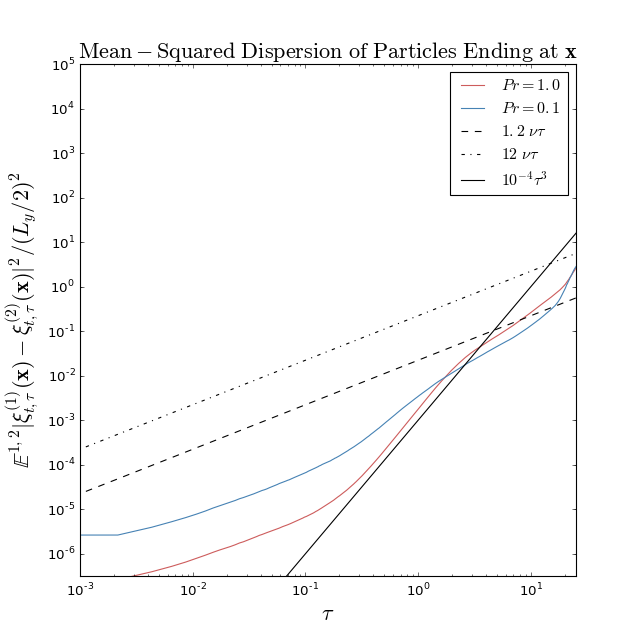

In [45]:
space_point_index = 0
kolmogorov_time = 1

half_Channel_Width = 0.5*(Top-Bottom)

kappa1 = nu/PrandtlNumbers[1]
kappa2 = nu/PrandtlNumbers[2]

Tau = tau/float(kolmogorov_time)
diffusion_dispersion1 = 12*kappa1*Tau
diffusion_dispersion2 = 12*kappa2*Tau
#diffusion_dispersion3 = 12*kappa3*Tau
Richardson_dispersion = 1e-3*Tau**3

disper1 = disp1[:, space_point_index]/float(half_Channel_Width**2)
disper2 = disp2[:, space_point_index]/float(half_Channel_Width**2)
#disper3 = disp[2,:, space_point_index]/float(half_Channel_Width**2)

fig = plt.figure(figsize=(8,8))
ax = fig.add_subplot(111)
ax.plot(Tau, disper1, color = 'Indianred', label = '$Pr = {0}$'.format(PrandtlNumbers[0]))
ax.plot(Tau, disper2, color = 'Steelblue', label = '$Pr = {0}$'.format(PrandtlNumbers[1]))
#ax.plot(Tau, disper3, color = 'green', label = '$Pr = {0}$'.format(PrandtlNumbers[2]))
ax.plot(Tau, diffusion_dispersion1,   color = 'black', linestyle = 'dashed',  label = '$1.2\ \\nu\\tau$')
ax.plot(Tau, diffusion_dispersion2,   color = 'black', linestyle = 'dashdot', label = '$12\  \\nu \\tau$')
#ax.plot(Tau, diffusion_dispersion3,   color = 'black', linestyle = 'dotted',  label = '$120\  \\nu \\tau$')
ax.plot(Tau, Richardson_dispersion,   color = 'black', linestyle = 'solid',   label = '$10^{-4} \\tau^3$')
ax.set_xlim([10**(-3),10**(1.4)])
ax.set_ylim([10**(-6.5),10**(5)])
ax.set_title('$\\rm Mean-Squared\ Dispersion\ of\ Particles\ Ending\ at\ \\mathbf{x}$', fontsize=20)
ax.set_xlabel('$\\tau $', fontsize=20)
ax.set_ylabel('$\mathbb{E}^{1,2} |{\\xi}^{(1)}_{t,\\tau}(\\mathbf{x})-{\\xi}^{(2)}_{t,\\tau}(\\mathbf{x})|^2 /(L_y/2)^2$', fontsize=20)
ax.set_yscale('log')
ax.set_xscale('log')
ax.legend(loc ="best")